# Confidence interval

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
import os

Algorithm:
1. Copy `X` to the new vector `X_clean`
2. Generate vector `X_diff` of the form
$$\mathbf x^* = (x^*_1, x^*_2, \dots, x^*_T) \\ x^*_t = \frac{x_t - x_{t-1}}{|\mathbf x|}$$
where $\mathbf x = (x_1, x_2, \dots, x_T)$
3. Find the the best confidence interval that separates outliers and signal in `X_diff` using elbow method
4. Delete observations from `X_clean` according to outliers in `X_diff`
5. Linearly interpolate deleted values
6. Repeat steps 2-5 once again

In [2]:
sample = pd.read_csv('../data/sample4.csv')

sample_diff = sample.copy()

X = sample.X / np.linalg.norm(sample.X)
sample_diff.X = np.concatenate(([0], (X[1:].values) - X[:-1].values))

Truth = sample.Truth / np.linalg.norm(sample.Truth)
sample_diff.Truth = np.concatenate(([0], (Truth[1:].values) - Truth[:-1].values))

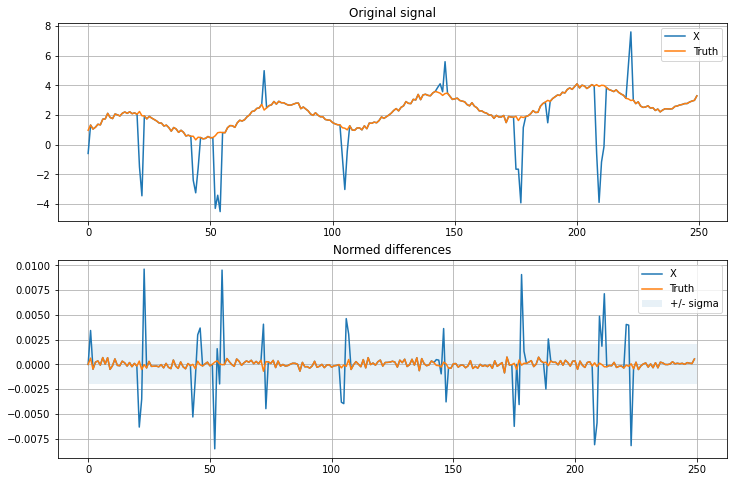

In [3]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
sample[:250].plot(ax=plt.gca())
plt.title('Original signal')
plt.grid()

plt.subplot(212)
sample_diff[:250].plot(ax=plt.gca())
plt.fill_between(
    [0, 250], 
    sample_diff.X.mean() + sample_diff.X.std(), 
    sample_diff.X.mean() - sample_diff.X.std(), 
    alpha=0.1,
    label='+/- sigma'
)

plt.title('Normed differences')
plt.legend()
plt.grid()

plt.show()

In [4]:
X_clean = sample.X.values.copy()

In [5]:
X_normed = X_clean / np.linalg.norm(X_clean)
X_diff = np.concatenate(([0], (X_normed[1:]) - X_normed[:-1]))

sigma_space = np.linspace(0, X_diff.max(), 100)
av_diff = X_diff.mean()
noise_space = np.array(
    [((X_diff <= av_diff - sigma) | (av_diff + sigma <= X_diff)).sum() for sigma in sigma_space]
)
diff = noise_space[1:] - noise_space[:-1]
best_sigma = sigma_space[np.argwhere(diff > -0.007 * X_diff.shape[0])[0][0]]

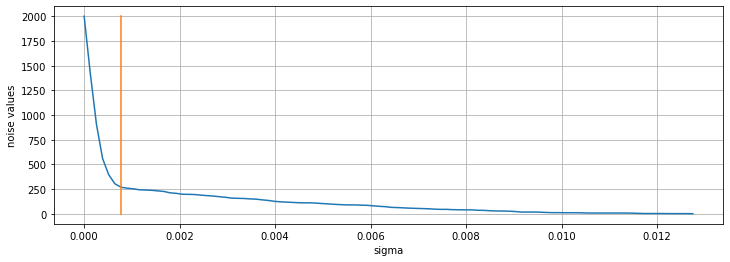

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(sigma_space, noise_space)
plt.plot([best_sigma, best_sigma], [0, X_diff.shape[0]])
plt.xlabel('sigma')
plt.ylabel('noise values')
plt.grid()
plt.show()

In [7]:
ratios_diff_noise = (
    np.abs(noise_space[2:] - noise_space[1:-1])
    / 
    (np.abs(noise_space[1:-1] - noise_space[:-2]) + 0.001)
)

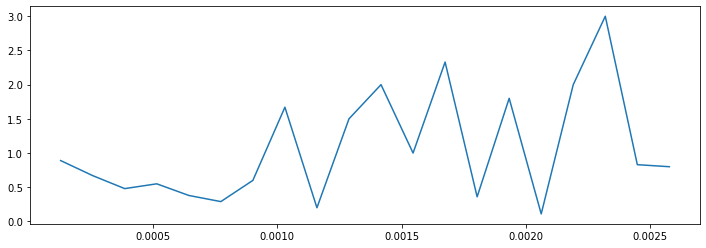

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(sigma_space[1:21], ratios_diff_noise.round(2)[:20] )
plt.show()

In [9]:
X_clean[np.argwhere((X_diff <= av_diff - best_sigma) | (av_diff + best_sigma <= X_diff))] = None
X_clean = pd.Series(X_clean).interpolate().values

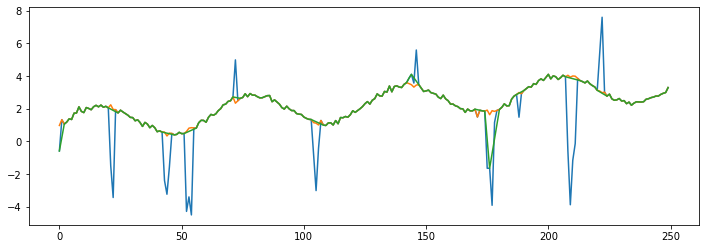

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(sample.X[:250])
plt.plot(sample.Truth[:250])
plt.plot(X_clean[:250])
plt.show()

In [11]:
def conf_int(X):
    X_clean = X.copy()
    for i in range(2):
        X_normed = X_clean / np.linalg.norm(X_clean)
        X_diff = np.concatenate(([0], (X_normed[1:]) - X_normed[:-1]))

        sigma_space = np.linspace(0, X_diff.max(), 100)
        av_diff = X_diff.mean()
        size_space = np.array(
            [((X_diff <= av_diff - sigma) | (av_diff + sigma <= X_diff)).sum() for sigma in sigma_space]
        )
        diff = size_space[1:] - size_space[:-1]
        best_sigma = sigma_space[np.argwhere(diff > -0.007 * X_diff.shape[0])[0][0]]

        X_clean[np.argwhere((X_diff <= av_diff - best_sigma) | (av_diff + best_sigma <= X_diff))] = None
        X_clean = pd.Series(X_clean).interpolate().values
    return X_clean

In [12]:
def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files

def run_tests(dir_path):
    
    print("Dataset: ", dir_path)
    files = get_files_list(dir_path)
    files.sort()
    
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    for afile in files:
        
        print("File: ", afile)
            
        data = pd.read_csv(afile, index_col=False)
        
        X      = data['X'].values
        X_true = data['Truth'].values
        
        X_clean = conf_int(X)
        
        rmse = mean_squared_error(X_true, X_clean, squared=False)
        
        report.loc[len(report)] = [afile, rmse]
        print("RMSE: ", rmse)
            
    return report

In [13]:
report_conf_int = run_tests('../data/')
report_conf_int

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.1267647514073364
File:  ../data/sample2.csv
RMSE:  0.08384650781316196
File:  ../data/sample3.csv
RMSE:  0.21986594035920434
File:  ../data/sample4.csv
RMSE:  0.14405496071788948
File:  ../data/sample5.csv
RMSE:  0.3533958315582855
File:  ../data/sample6.csv
RMSE:  1.0524094300871423
File:  ../data/sample7.csv
RMSE:  4.76584509365803
File:  ../data/sample8.csv
RMSE:  0.36477687971282985
File:  ../data/sample9.csv
RMSE:  113.32405398239375


Sample        RMSE
0  ../data/sample1.csv    0.126765
1  ../data/sample2.csv    0.083847
2  ../data/sample3.csv    0.219866
3  ../data/sample4.csv    0.144055
4  ../data/sample5.csv    0.353396
5  ../data/sample6.csv    1.052409
6  ../data/sample7.csv    4.765845
7  ../data/sample8.csv    0.364777
8  ../data/sample9.csv  113.324054

In [14]:
board = pd.DataFrame(columns=['Data preparation', 'Model']+['sample'+str(i) for i in range(1, 10)])
board.loc[len(board)] = ['Neighbors\' difference', 'Threshold'] + list(report_conf_int['RMSE'].values)
board = board.set_index(['Data preparation', 'Model'])
board

sample1   sample2   sample3   sample4  \
Data preparation      Model                                               
Neighbors' difference Threshold  0.126765  0.083847  0.219866  0.144055   

                                  sample5   sample6   sample7   sample8  \
Data preparation      Model                                               
Neighbors' difference Threshold  0.353396  1.052409  4.765845  0.364777   

                                    sample9  
Data preparation      Model                  
Neighbors' difference Threshold  113.324054

In [15]:
board.iloc[[0], :].to_csv('../results/neigh_diff_conf_int.csv')